In [ ]:
!pip install pycuda



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.8 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661205 sha256=e8ef504030c9a5e830a205d9d44cccf846459470d8e6c1a0bdbe8ae85b400dbc
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


In [ ]:
!nvidia-smi


Tue Feb 13 01:20:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              28W /  70W |    109MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install pyngrok



/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


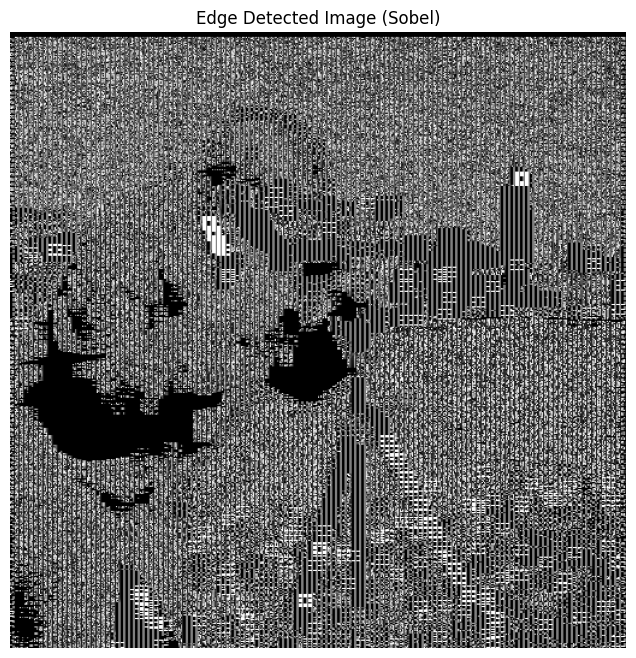

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
image_gray = data.camera()
sobel_kernel_code = """
__global__ void sobel_edge_detection(float *input, float *output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int idx = y * width + x;

    if (x > 0 && x < width - 1 && y > 0 && y < height - 1) {
        float dx = input[(y - 1) * width + (x + 1)] - input[(y - 1) * width + (x - 1)]
                 + 2 * input[y * width + (x + 1)] - 2 * input[y * width + (x - 1)]
                 + input[(y + 1) * width + (x + 1)] - input[(y + 1) * width + (x - 1)];

        float dy = input[(y + 1) * width + (x - 1)] - input[(y - 1) * width + (x - 1)]
                 + 2 * input[(y + 1) * width + x] - 2 * input[(y - 1) * width + x]
                 + input[(y + 1) * width + (x + 1)] - input[(y - 1) * width + (x + 1)];

        output[idx] = sqrt(dx * dx + dy * dy);
    }
}
"""

mod = SourceModule(sobel_kernel_code)
sobel_edge_detection_kernel = mod.get_function("sobel_edge_detection")

# Define image dimensions
height, width = image_gray.shape

# Allocate GPU memory for input and output images
input_gpu = cuda.mem_alloc(image_gray.nbytes)
output_gpu = cuda.mem_alloc(image_gray.nbytes)

# Transfer input image from CPU to GPU
cuda.memcpy_htod(input_gpu, image_gray)

# Define block and grid dimensions for CUDA kernel launch
block = (16, 16, 1)
grid = ((width + block[0] - 1) // block[0], (height + block[1] - 1) // block[1], 1)

# Launch Sobel edge detection CUDA kernel
sobel_edge_detection_kernel(input_gpu, output_gpu, np.int32(width), np.int32(height), block=block, grid=grid)

# Transfer the edge-detected image from GPU to CPU
output_cpu = np.empty_like(image_gray)
cuda.memcpy_dtoh(output_cpu, output_gpu)

# Display the edge-detected image
plt.figure(figsize=(8, 8))
plt.imshow(output_cpu, cmap='gray')
plt.title('Edge Detected Image (Sobel)')
plt.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


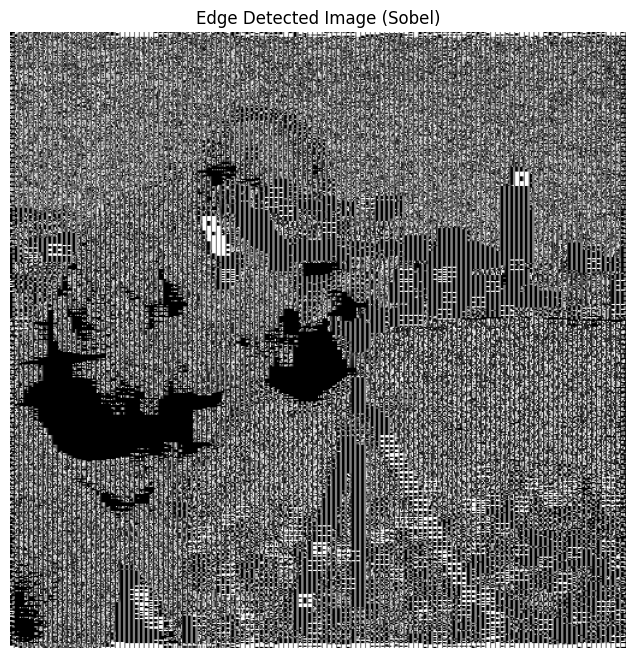

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

# Load a sample image from scikit-image (e.g., camera)
image_gray = data.camera()

# Define Sobel edge detection CUDA kernel code
sobel_kernel_code = """
__global__ void sobel_edge_detection(float *input, float *output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int idx = y * width + x;

    if (x > 0 && x < width - 1 && y > 0 && y < height - 1) {
        float dx = input[(y - 1) * width + (x + 1)] - input[(y - 1) * width + (x - 1)]
                 + 2 * input[y * width + (x + 1)] - 2 * input[y * width + (x - 1)]
                 + input[(y + 1) * width + (x + 1)] - input[(y + 1) * width + (x - 1)];

        float dy = input[(y + 1) * width + (x - 1)] - input[(y - 1) * width + (x - 1)]
                 + 2 * input[(y + 1) * width + x] - 2 * input[(y - 1) * width + x]
                 + input[(y + 1) * width + (x + 1)] - input[(y - 1) * width + (x + 1)];

        output[idx] = sqrt(dx * dx + dy * dy);
    }
}
"""

# Compile Sobel edge detection CUDA kernel
mod = SourceModule(sobel_kernel_code)
sobel_edge_detection_kernel = mod.get_function("sobel_edge_detection")

# Define image dimensions
height, width = image_gray.shape

# Allocate GPU memory for input and output images
input_gpu = cuda.mem_alloc(image_gray.nbytes)
output_gpu = cuda.mem_alloc(image_gray.nbytes)

# Transfer input image from CPU to GPU
cuda.memcpy_htod(input_gpu, image_gray)

# Define block and grid dimensions for CUDA kernel launch
block = (16, 16, 1)
grid = ((width + block[0] - 1) // block[0], (height + block[1] - 1) // block[1], 1)

# Launch Sobel edge detection CUDA kernel
sobel_edge_detection_kernel(input_gpu, output_gpu, np.int32(width), np.int32(height), block=block, grid=grid)

# Transfer the edge-detected image from GPU to CPU
output_cpu = np.empty_like(image_gray)
cuda.memcpy_dtoh(output_cpu, output_gpu)

# Display the edge-detected image
plt.figure(figsize=(8, 8))
plt.imshow(output_cpu, cmap='gray')
plt.title('Edge Detected Image (Sobel)')
plt.axis('off')
plt.show()


Saving new pic .jpg to new pic .jpg


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.10/dist-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


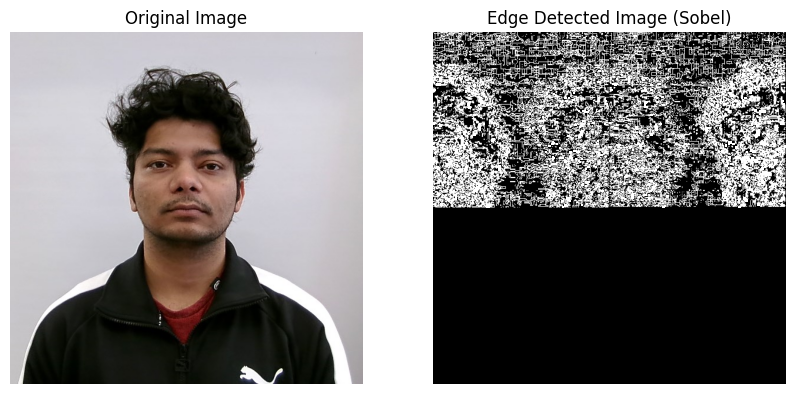

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from google.colab import files

# Upload an image from your local system
uploaded = files.upload()

# Get the uploaded image filename
image_filename = next(iter(uploaded))

# Load the uploaded image
image = plt.imread(image_filename)

# Convert the uploaded image to grayscale
image_gray = color.rgb2gray(image)

# Define Sobel edge detection CUDA kernel code
sobel_kernel_code = """
__global__ void sobel_edge_detection(float *input, float *output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int idx = y * width + x;

    if (x > 0 && x < width - 1 && y > 0 && y < height - 1) {
        float dx = input[(y - 1) * width + (x + 1)] - input[(y - 1) * width + (x - 1)]
                 + 2 * input[y * width + (x + 1)] - 2 * input[y * width + (x - 1)]
                 + input[(y + 1) * width + (x + 1)] - input[(y + 1) * width + (x - 1)];

        float dy = input[(y + 1) * width + (x - 1)] - input[(y - 1) * width + (x - 1)]
                 + 2 * input[(y + 1) * width + x] - 2 * input[(y - 1) * width + x]
                 + input[(y + 1) * width + (x + 1)] - input[(y - 1) * width + (x + 1)];

        output[idx] = sqrt(dx * dx + dy * dy);
    }
}
"""

# Compile Sobel edge detection CUDA kernel
mod = SourceModule(sobel_kernel_code)
sobel_edge_detection_kernel = mod.get_function("sobel_edge_detection")

# Define image dimensions
height, width = image_gray.shape

# Allocate GPU memory for input and output images
input_gpu = cuda.mem_alloc(image_gray.nbytes)
output_gpu = cuda.mem_alloc(image_gray.nbytes)

# Transfer input image from CPU to GPU
cuda.memcpy_htod(input_gpu, image_gray)

# Define block and grid dimensions for CUDA kernel launch
block = (16, 16, 1)
grid = ((width + block[0] - 1) // block[0], (height + block[1] - 1) // block[1], 1)

# Launch Sobel edge detection CUDA kernel
sobel_edge_detection_kernel(input_gpu, output_gpu, np.int32(width), np.int32(height), block=block, grid=grid)

# Transfer the edge-detected image from GPU to CPU
output_cpu = np.empty_like(image_gray)
cuda.memcpy_dtoh(output_cpu, output_gpu)

# Display the uploaded image and the edge-detected image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_cpu, cmap='gray')
plt.title('Edge Detected Image (Sobel)')
plt.axis('off')

plt.show()
